# 一、利用 Newton-Raphson 算法实现逻辑回归

令$p(x;\beta) = \frac{exp(x^T \beta)}{1 + exp(x^T \beta)} = \frac{1}{1 + exp(-x^T \beta)}$

对数似然函数 $l(\beta) = \Sigma_{i=1}^n [y_i log p(x_i;\beta) + (1-yi)log(1-p(x_i;\beta))]$

根据链式法则，$\frac{\partial p(x;\beta)}{\partial \beta} = p(x;\beta) (1-p(x;\beta)) x$

进而，$\frac{\partial l(\beta)}{\partial \beta} = \Sigma_{i=1}^n [y_i \frac{1}{p} p (1-p)x_i - (1-y_i) \frac{1}{1-p} p (1-p) x_i]$

$=\Sigma_{i=1}^n [y_i(1-p)x_i - (1-y_i)px_i]$

$=\Sigma_{i=1}^n [(y_i - p(x_i; \beta))x_i]\cdots$记作$g_k$

海森矩阵$\frac{\partial^2 l(\beta)}{\partial \beta \partial \beta ^ T} = -\Sigma x_i x_i^T p(x_i;\beta)(1 - p(x_i;\beta))\cdots$记作$H_k$

牛顿法更新公式为$x_{k+1} = x_k - H_k^{-1} g_k$

按照上述步骤实现优化按题意进行逻辑回归，代码如下：

In [1]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

## （1） 设置真实参数值 

In [2]:
beta = np.array([-0.5, 0.5,-1, 1])

## (2) 生成X

In [3]:
def generate_x(N:int):
    x1 = np.ones((N, 1))
    x2 = np.random.normal(size = (N,3))
    x = np.concatenate([x1,x2], 1)
    return x

## (3)牛顿法迭代

设置超参数

In [4]:
R = 200
N_list = [200, 500, 750, 1000]

根据公式写出迭代函数

In [5]:
def p(x, beta):
    return 1/(1 + np.exp(- x @ beta))
def g(x,beta, y):
    return (y - p(x,beta)) @ x
def H(x, beta):
    s = 0
    for xi in x:
        xi1 = xi.reshape(4,1)
        xi2 = xi.reshape(1,4)
        pp = p(xi, beta)
        s += xi1@xi2 * pp * (1-pp)
    return -s

根据公式写出生成y的函数:服从伯努利分布(1,p)

In [6]:
def generate_y(x, beta):
    y_prob = p(x, beta)
    y_prob = np.random.binomial(1, y_prob)
#     y_prob[y_prob > 0.5] = 0.9
#     y_prob[y_prob <=  0.5] = 0.1
    return y_prob

使用牛顿迭代,根据x和y估计$\beta$

In [7]:
def newton(x,y):
#     beta0 = np.random.normal(size = 4)# 随机初始化参数,容易发生梯度爆炸，不如都初始为0
    beta0 = np.array([0,0,0,0])
    count = 0
    while 1:
        gx = g(x, beta0, y)
        try:
            beta1 = beta0 - np.linalg.inv(H(x, beta0)) @ gx
        except:
#             beta1 = beta0 - np.linalg.pinv(H(x, beta0)) @ gx
            beta1 = beta0
            break
        beta1 = np.asarray(beta1).squeeze()
        if np.max(np.abs(beta1 - beta0)) < 10 ** (-5) or count > 500:
            break
        beta0 = beta1
        count += 1
    return beta1,count

In [8]:
beta_hats = list()
for r in tqdm(range(R)):
    np.random.seed(r)
    for N in N_list:
        x = generate_x(N)
        y = generate_y(x, beta)
        beta_hat = newton(x, y)
        beta_hats.append(beta_hat)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.90it/s]


## （4）箱线图

In [9]:
names = ['j=1','j=2','j=3','j=4']
box_list = list()
for N in N_list: 
    box = [[],[],[],[]]
    for r in tqdm(range(R)):
        np.random.seed(r)
        x = generate_x(N)
        y = generate_y(x, beta)
        beta_hat = newton(x, y)[0]
        for i in range(4):
            box[i].append(beta_hat[i] - beta[i])
    box_list.append(box)
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.91it/s]


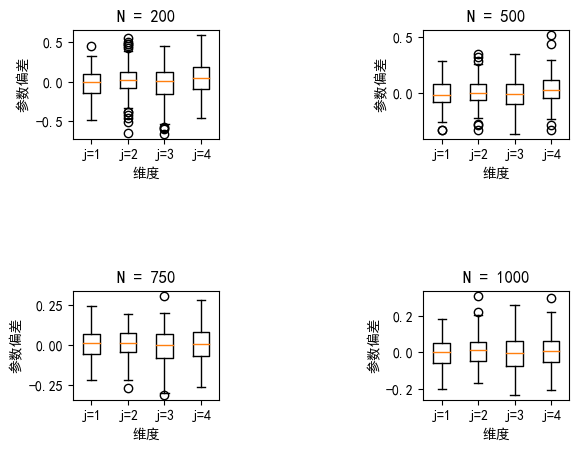

In [10]:
count = 0
pos = [331, 333, 337, 339]
for N in N_list:
    ax = plt.subplot(pos[count])
    ax.boxplot(box_list[count])
    count += 1
    ax.set_xticklabels(names)
    plt.xlabel('维度')
    plt.ylabel('参数偏差')
    plt.title(f'N = {N}')
plt.show()

观察箱线图可以发现规律： \
随着N的增大，箱高逐渐缩小(从纵坐标能够明显看出)。这说明随着样本量的增大，参数偏的方差在逐渐减小。

# 二、征信系列-用户行为数据分析

## 1 读取数据

In [11]:
df = pd.read_csv('simudata.csv')
df.head(10)

,creded,debitF,meanpay,billnum,debitM,zhongxingM,sidaM,xindaiR,cardnum,xindaiF,...,sidaR,zhongxingF,zhongxingR,xiaofeiF,jinkaF,zhuanzhangM,gongjiaoM,youxiM,xindaiS,black
0,0.02,28,474795,4,784137.54,56826,307042,365.00,2,6,...,7.83,4,334.38,6,9,508646.02,297.83,66.02,5760.22,1
1,0.16,2,346573,32,1217.43,43644,15096,311.73,9,0,...,91.77,14,365.00,1,11,425876.24,3521.03,22.75,83872.62,1
2,0.32,56,168844,191,95001.76,279217,69815,42.32,8,0,...,36.05,10,27.08,1,2,492287.84,467.64,6.66,31110.55,1
3,0.01,28,69002,89,487782.48,273731,329437,81.60,15,1,...,10.08,8,191.04,1,8,240067.26,288.67,119.98,7876.13,1
4,0.19,6,408647,104,22039.56,13529,24725,254.60,17,9,...,324.21,23,248.39,7,0,455464.47,11834.25,28.97,13765.38,0
5,0.20,65,285313,3,194798.70,11285,17961,50.31,5,0,...,237.08,0,361.47,4,0,192392.72,527.81,27.45,161711.43,0
6,0.02,39,95582,47,683038.80,493431,101076,193.43,4,4,...,277.95,25,254.59,4,0,370075.36,32316.57,539.21,108730.17,1
7,0.05,3,291786,65,2752.78,332524,135872,182.72,1,2,...,97.87,20,198.89,2,4,50414.81,11126.52,37.76,148837.36,0
8,0.01,54,121819,82,173684.82,34654,23808,61.76,2,4,...,290.85,0,160.41,3,1,911546.39,1564.29,613.75,3313.78,1
9,0.01,65,10925,2,628214.70,9164,802955,262.19,1,0,...,22.75,13,269.27,4,0,639331.16,994.75,357.74,5686.27,0


## 2 箱线图

对变量交易笔数和所有用户行为均值分别绘制违约组和非违约组的对比箱线图

In [12]:
data_0 = df[df['black'] == 0] # 非违约样本
data_1 = df[df['black'] == 1] # 违约样本

首先绘制用户交易笔数的是否违约对比箱线图

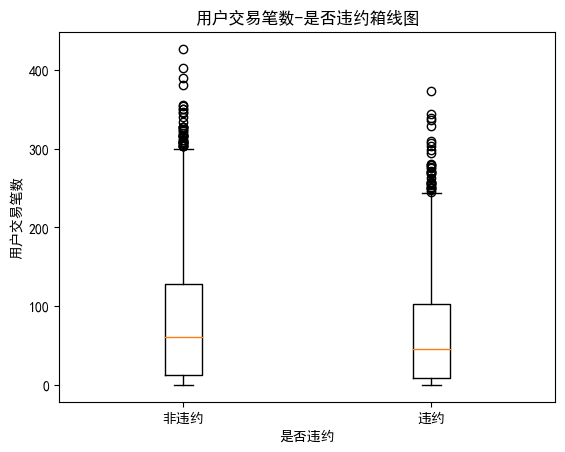

In [13]:
var_name = 'billnum'
names = ['非违约','违约']
box = [data_0[var_name], data_1[var_name]]
ax = plt.subplot()
ax.boxplot(box)
ax.set_xticklabels(names)
plt.xlabel('是否违约')
plt.ylabel('用户交易笔数')
plt.title(f'用户交易笔数-是否违约箱线图')
plt.show()

绘制用户行为均值：

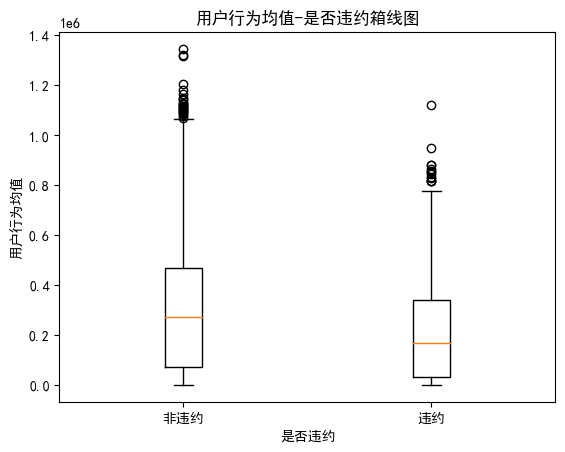

In [14]:
var_name = 'meanpay'
names = ['非违约','违约']
box = [data_0[var_name], data_1[var_name]]
ax = plt.subplot()
ax.boxplot(box)
ax.set_xticklabels(names)
plt.xlabel('是否违约')
plt.ylabel('用户行为均值')
plt.title(f'用户行为均值-是否违约箱线图')
plt.show()

分析解读：两组箱线图具有高度的一致性，说明违约用户相较于非违约用户，其交易笔数和行为均值都更小，且分布更加集中。

## 3 逻辑回归与变量选择

BIC公式为：$-2L(B) + (log N)d$，这里$L(B)$是似然函数，N为样本量，d是维度数量

逻辑回归的似然函数为：

$$L(\beta) = \Pi_{i=1}^n P(Y_i|X_i) = \Pi_{i=1}^n \{\frac{exp(x_i ^T \beta)}{1 + exp(x_i ^T \beta)}\}^{Y_i}\{\frac{1}{1 + exp(x_i ^T \beta)}\}^{1 - Y_i} $$

据此写出对数似然函数：（之所以用对数似然函数，而不用原本的似然函数，是因为原本似然函数是概率连乘，结果都比较接近0，没有区分度）

In [15]:
def p(x, beta):
    return 1/(1 + np.exp(- x @ beta))


def loglikelihood(x, beta, y):
    length = len(x)
    initial = 0
    for i in range(length):
        if y[i] == 1:
            initial += np.log(p(x[i], beta))
        else:
            initial += np.log((1 - p(x[i], beta)))
    return initial

可以尝试通过向前选择的方式，每次新加入一个特征使得BIC最小

In [16]:
y = df['black']
column_names = df.columns

In [17]:
candicate = list(df.columns[0:len(column_names) - 1])
features = list()
N = len(df)
for i in range(len(candicate)):
    bic_min = float('inf')
    for j in candicate:
        features_tmp = features + [j]
        d = len(features_tmp)
        x = np.asarray(df[features_tmp])
        model = LogisticRegression().fit(x, y)
        beta_hat = model.coef_.reshape((-1,1))
        L = loglikelihood(x, beta_hat, y)
        bic = -2 * L + np.log(N) * d
        if bic < bic_min:
            bic_min = bic
            best_candicate = j
    features.append(best_candicate)
    candicate.remove(best_candicate)
    print(best_candicate, bic_min)

meanpay [9966.81016746]
debitF [9790.80966357]
xindaiR [9572.93770318]
sidaM [9400.03472593]
zhuanzhangF [9340.26072945]
billnum [9187.9294336]
zhuanzhangR [9174.08128998]
xiaofeiF [9182.01466996]
gongjiaoR [9161.66586337]
cardnum [9160.34483391]
sidaF [9159.84299494]
xindaiF [9163.265889]
xindaiS [9165.57494519]
gongjiaoF [9196.41449046]
zhongxingF [9185.2347506]
jinkaF [9196.36798677]
creded [9200.02557228]
maxpay [9264.56780939]
sidaR [9193.14845166]
zhongxingM [9193.02651625]
debitM [9273.07759644]
zhuanzhangM [9280.78748453]
age [9281.31539225]
zhongxingR [9313.38765482]
youxiM [9384.89410931]
gongjiaoM [9571.73737714]


上述过程为向前选择，每次添加一个BIC最小变量，可见在添加sidaF变量后，全局BIC达到最小值9159.8，因此最佳的变量组合为：

In [18]:
best_combination = ['meanpay','debitF','xindaiR','sidaM','zhuanzhangF','billnum','zhuanzhangR','xiaofeiF','gongjiaoR','cardnum','sidaF']

In [19]:
x = np.asarray(df[best_combination])
model = LogisticRegression().fit(x, y)
beta_hat = model.coef_.reshape((-1,1))

In [20]:
beta_hat

array([[-2.12200455e-06],
       [-1.02291255e-02],
       [ 4.06328800e-03],
       [-1.10053643e-06],
       [ 7.79777103e-03],
       [-5.48960734e-03],
       [ 1.24500456e-03],
       [ 3.95838413e-04],
       [-1.00217589e-03],
       [ 2.02171932e-03],
       [ 2.31631848e-03]])

对系数的解释： \
由于这里没有事先对x做标准化或者归一化，所以系数的绝对值大小不能作为互相比较的依据。但是可以从系数的正负看出各个变量对于被预测变量（是否违约）呈正相关还是负相关。 \
行为均值、借记类F、四大行M、交易笔数、公缴类R这五个变量越大，则用户的违约概率越小。 \
而信贷类R、转账类F、转账类R、消费类F、银行卡数、四大行F者六个变量越大，则用户的违约概率越大。

# AUC & ROC

In [21]:
ypre = model.predict_proba(x)[:, 1]

In [22]:
FPR,TPR,threshold=roc_curve(y,ypre,pos_label=1)

In [23]:
AUC=auc(FPR,TPR)
print(AUC)

0.7236975855029784


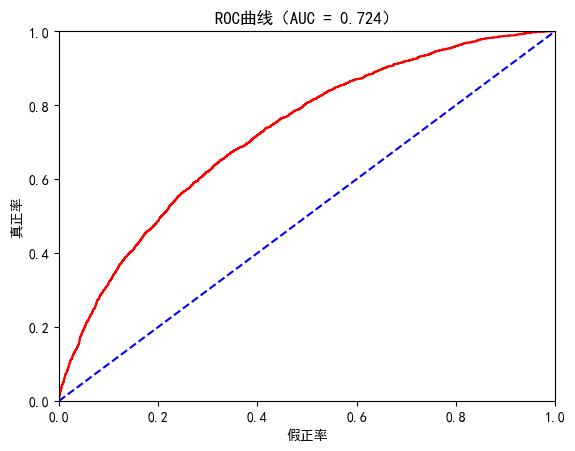

In [24]:
plt.figure()
plt.title(f'ROC曲线（AUC = {round(AUC, 3 )}）')
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.plot(FPR,TPR,color='r')
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.show()

ROC曲线明显向左上凸起，曲线下面积为0.724，逻辑回归拟合效果良好。

## 5 非违约人群柱状图

In [25]:
white = sorted((1 - ypre))[::-1]
height = len(white) // 5
a,b,c,d,e = np.mean(white[0:height]),np.mean(white[height:2 * height]),np.mean(white[2 * height:3 * height]),np.mean(white[3 * height:4 * height]),np.mean(white[4 * height:])

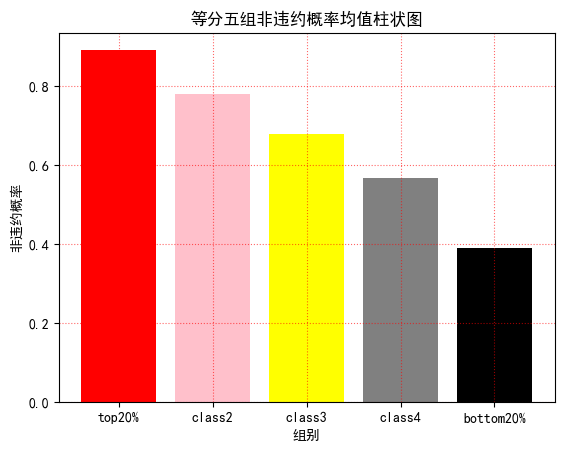

In [26]:
x=[1,2,3,4,5]  
y=[a,b,c,d,e]  

color=['red','pink','yellow','grey','black']
x_label=['top20%','class2','class3','class4','bottom20%']
plt.xticks(x, x_label)  # 绘制x刻度标签
plt.bar(x, y,color=color)  # 绘制y刻度标签
plt.title(f'等分五组非违约概率均值柱状图')
plt.xlabel('组别')
plt.ylabel('非违约概率')
#设置网格刻度
plt.grid(True,linestyle=':',color='r',alpha=0.6)
plt.show()

商业用途解读：可以从途中看出，非违约概率的分布显示出极端、集中的特点，非违约概率在前40%的人群中都比较高，但是在最后20%展示出骤降。这说明在信贷问题中，提取用户特征进行违约评级后，应该对违约风险位列前茅的少部分用户进行严格防范，这一小批人群的违约概率很高。